In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults,ARMA,ARMAResults
import statsmodels.api as sm
from matplotlib.pylab import rcParams
from statsmodels.tools.eval_measures import rmse

from sklearn.preprocessing import MinMaxScaler

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation,performance_metrics
from fbprophet.plot import plot_cross_validation_metric


import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [2]:
# pip install pmdarima

In [3]:
df=pd.read_csv('/content/drive/My Drive/airline_passengers.csv')

In [4]:
df.columns=['date','passengers']

In [5]:
df.head()

,date,passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [6]:
#dropping null values
df.dropna(inplace=True)

In [7]:
df['date']=pd.to_datetime(df['date'])

In [8]:
df.set_index('date',inplace=True)

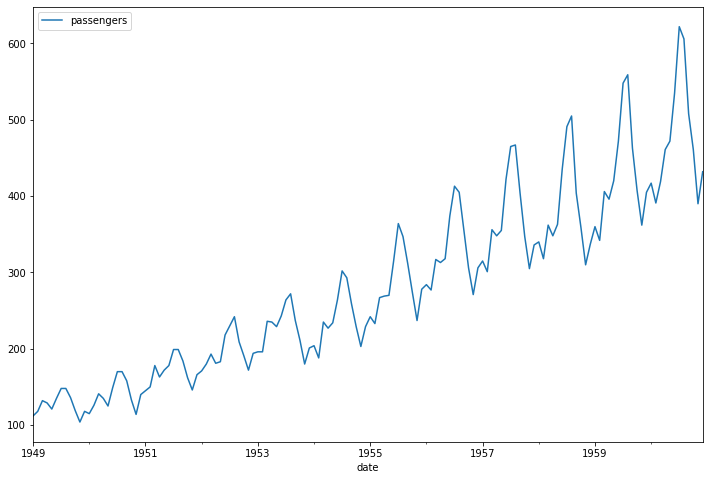

In [9]:
df.plot(figsize=(12,8))

In [10]:
decomposition=seasonal_decompose(df)
trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid

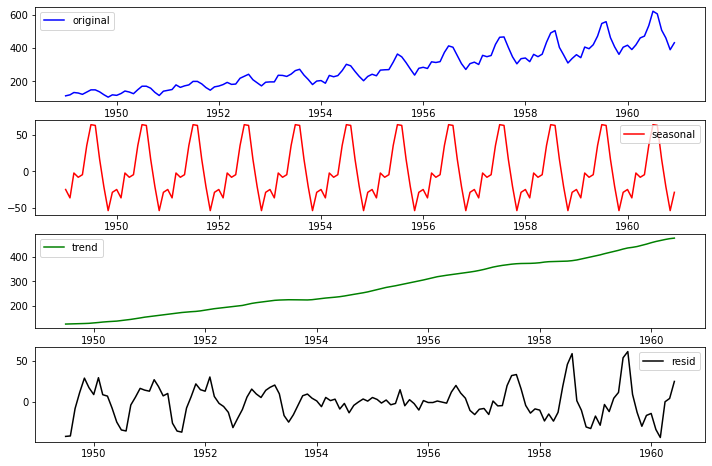

In [11]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df,label='original',color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(seasonal,label='seasonal',color='red')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(trend,label='trend',color='green')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='resid',color='black')
plt.legend(loc='best')

In [12]:
# Finding if data is seasonal

In [13]:
# rolling mean & std
roll_mean=df.rolling(window=8).mean()
roll_std=df.rolling(window=8).std()

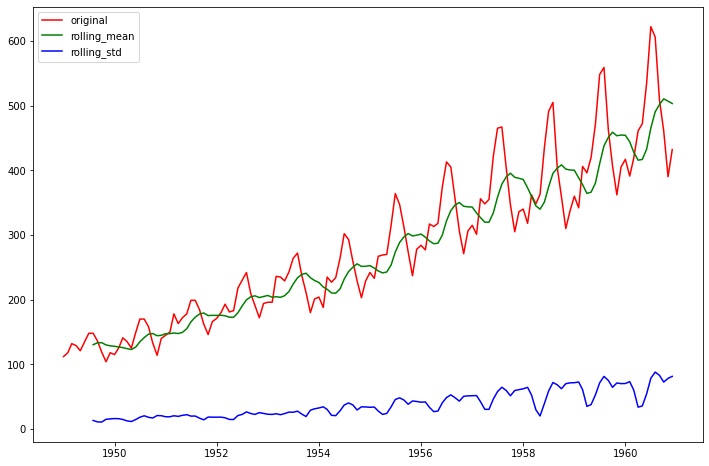

In [14]:
fig=plt.figure(figsize=(12,8))
plt.plot(df,color='red',label='original')
plt.plot(roll_mean,color='green',label='rolling_mean')
plt.plot(roll_std,color='blue',label='rolling_std')
plt.legend(loc='best')
plt.show()

In [15]:
# dickeyfuller test
dftest=adfuller(df['passengers'])
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)

print ('Results of Dickey-Fuller test: \n')

print(dfoutput)



(0.815368879206047, 0.991880243437641, 13, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 996.6929308390189)
Results of Dickey-Fuller test: 

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [16]:
# function to chect stationary

def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS['passengers'])
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    plt.plot(TS, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None


In [17]:
# lets make the data stationary

In [18]:
# log transformation
log_df=np.log(df)

In [19]:
# Calculate Weighted Moving Average of log transformed data
exp_roll_mean=log_df.ewm(halflife=4).mean()

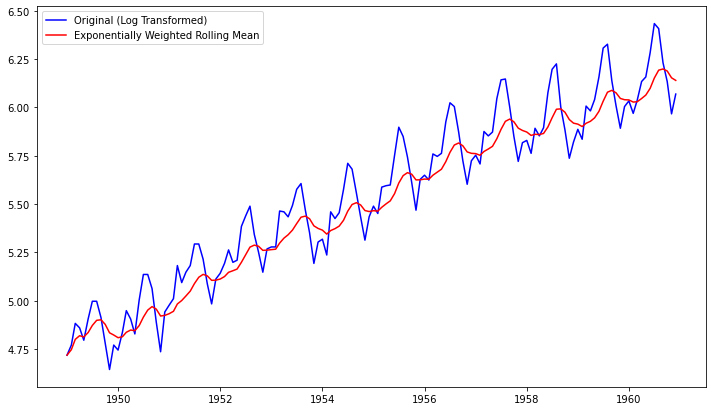

In [20]:
# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
plt.plot(np.log(df), color='blue',label='Original (Log Transformed)')
plt.plot(exp_roll_mean, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.show(block=False)

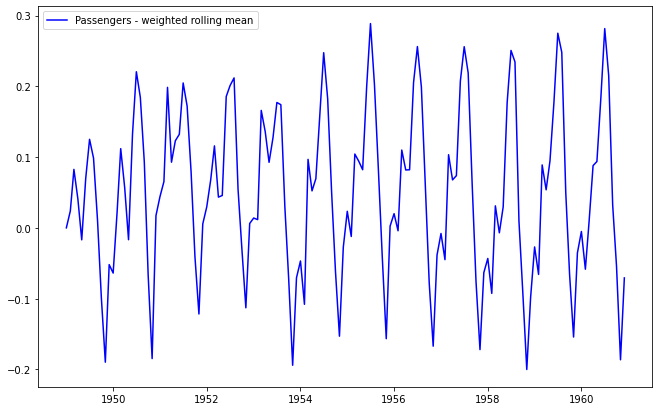

In [21]:
# substracting ewm from log data
data_minus_exp_roll_mean = np.log(df) - exp_roll_mean
# Plot the time series
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_roll_mean, color='blue',label='Passengers - weighted rolling mean')
plt.legend(loc='best')
plt.show(block=False)

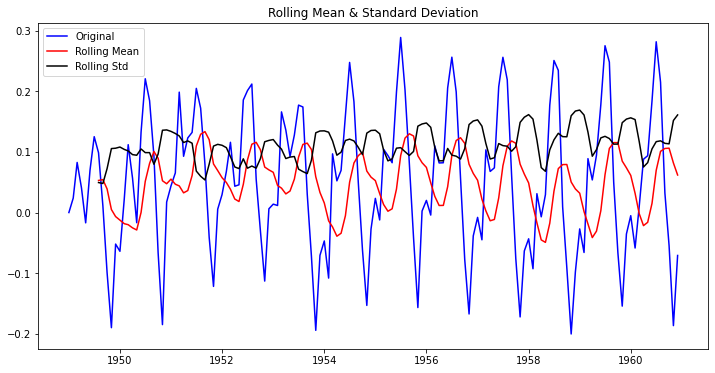

Results of Dickey-Fuller Test: 

Test Statistic                  -3.297250
p-value                          0.015002
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [22]:
stationarity_check(data_minus_exp_roll_mean)

In [23]:
# differencing
data_diff=data_minus_exp_roll_mean.diff(periods=12)
data_diff.dropna(inplace=True)

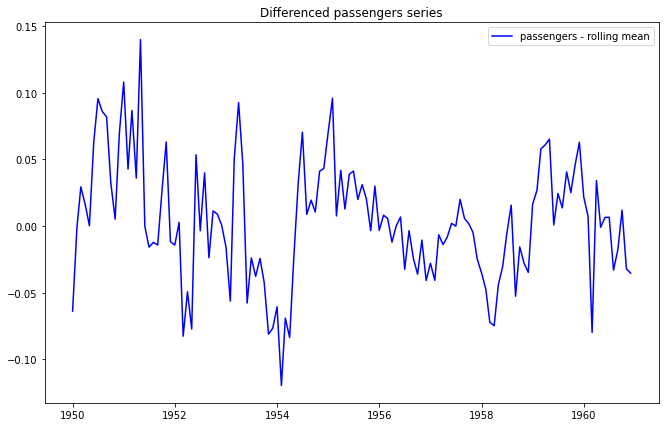

In [24]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff, color='blue',label='passengers - rolling mean')
plt.legend(loc='best')
plt.title('Differenced passengers series')
plt.show(block=False)


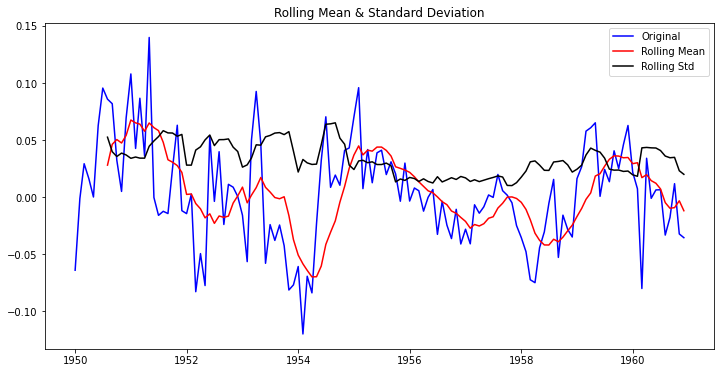

Results of Dickey-Fuller Test: 

Test Statistic                  -3.601666
p-value                          0.005729
#Lags Used                      12.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [25]:
stationarity_check(data_diff)

In [26]:
# ACF & Pacf

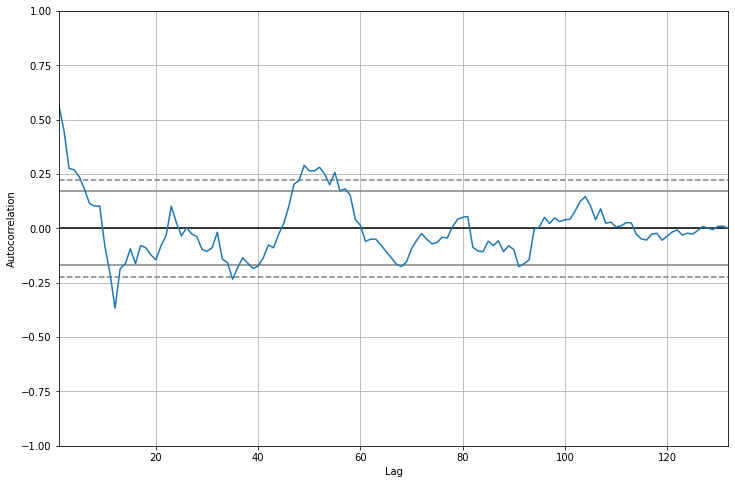

In [27]:
plt.figure(figsize=(12,8))
pd.plotting.autocorrelation_plot(data_diff)

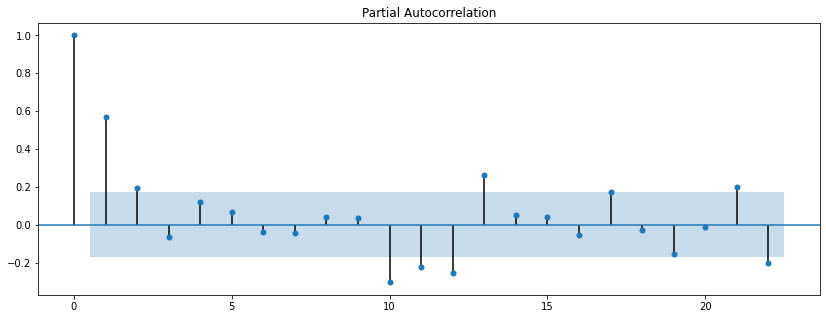

In [28]:
rcParams['figure.figsize'] = 14, 5
plot_pacf(data_diff);

ARIMA MODEL

In [29]:
arima_model=auto_arima(data_diff['passengers'],start_P=1,start_q=1,max_p=3,max_q=3,
                       m=12,seasonal=True,d=None,D=1,trace=True,error_action='ignore',
                       suppress_warnings=True,stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.82 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-275.531, Time=0.12 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-377.289, Time=1.05 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-277.129, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-318.685, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-394.588, Time=3.02 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.94 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.33 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-342.556, Time=1.65 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-399.238, Time=3.02 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=-381.117, Time=1.05 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.79 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.53 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=-397.2

In [30]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  132
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 12)   Log Likelihood                 205.770
Date:                             Sun, 18 Oct 2020   AIC                           -401.541
Time:                                     20:47:19   BIC                           -387.603
Sample:                                          0   HQIC                          -395.881
                                             - 132                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8554      0.075     11.336      0.000       0.708       1.003
ma.L1         -0.4096      0.121     -3.372      0.001      -0.648      -0.171
ar.S.L12      -0.9914      0.091    -10.870      0.000      -1.170      -0.813
ar.S.L24      -0.4646      0.097     -4.770      0.000      -0.656      -0.274
sigma2         0.0017      0.000      6.505      0.000       0.001       0.002
===================================================================================
Ljung-Box (Q):                       50.90   Jarque-Bera (JB):                 0.74
Prob(Q):                              0.12   Prob(JB):                         0.69
Heteroskedasticity (H):               0.49   Skew:                             0.17
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
model=sm.tsa.statespace.SARIMAX(df['passengers'],
                                order=(1, 0, 1),
                                seasonal_order=(2, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results=model.fit()
results.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          passengers   No. Observations:                  144
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 12)   Log Likelihood                -419.001
Date:                             Sun, 18 Oct 2020   AIC                            848.002
Time:                                     20:47:24   BIC                            861.366
Sample:                                 01-01-1949   HQIC                           853.420
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9760      0.026     37.148      0.000       0.924       1.027
ma.L1         -0.3499      0.092     -3.821      0.000      -0.529      -0.170
ar.S.L12      -0.0983      0.114     -0.859      0.390      -0.323       0.126
ar.S.L24       0.2331      0.125      1.862      0.063      -0.012       0.478
sigma2       147.3530     20.565      7.165      0.000     107.046     187.660
===================================================================================
Ljung-Box (Q):                       47.26   Jarque-Bera (JB):                 2.48
Prob(Q):                              0.20   Prob(JB):                         0.29
Heteroskedasticity (H):               1.97   Skew:                             0.19
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
forecast=results.predict(start= len(df),end=len(df)+24,typ='levels').rename('data arima (1,0,1) forecast')

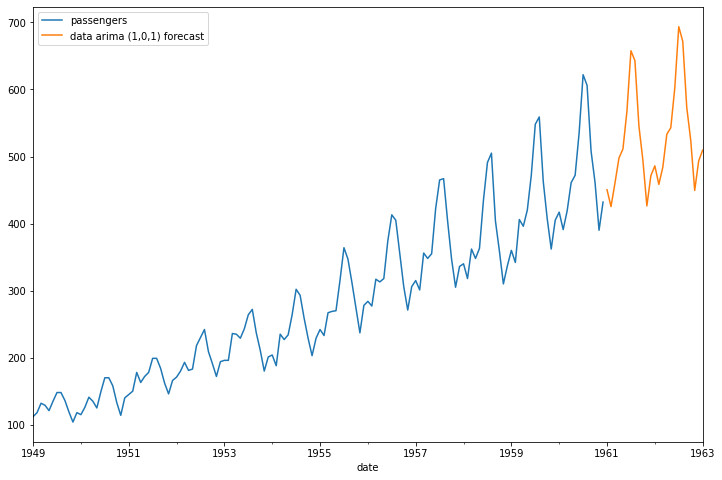

In [33]:
df['passengers'].plot(figsize=(12,8),legend=True)
forecast.plot(legend=True)

In [34]:
arima_model1=auto_arima(df['passengers'],start_P=1,start_q=1,max_p=3,max_q=3,
                       m=12,seasonal=True,d=None,D=1,trace=True,error_action='ignore',
                       suppress_warnings=True,stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=1018.248, Time=2.28 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.30 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1018.359, Time=1.11 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=1017.914, Time=1.11 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1017.847, Time=0.26 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.06 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=1022.393, Time=0.05 sec
 ARIMA(3,1,1)(0,1,0)[12]             : AIC=1019.084, Time=0.36 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=1019.290, Time=0.37 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.05 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1024.160, Time=0.16 sec
 ARIMA(3,1,0)(0,1,0)[12]             : AIC=1023.666, Time=0.11 sec
 ARIMA(3,1,2)(0,1,0

In [35]:
arima_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                -504.923
Date:                             Sun, 18 Oct 2020   AIC                           1017.847
Time:                                     20:52:39   BIC                           1029.348
Sample:                                          0   HQIC                          1022.520
                                             - 144                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5960      0.085      6.987      0.000       0.429       0.763
ar.L2          0.2143      0.091      2.343      0.019       0.035       0.394
ma.L1         -0.9819      0.038    -25.596      0.000      -1.057      -0.907
sigma2       129.3130     14.556      8.884      0.000     100.783     157.843
===================================================================================
Ljung-Box (Q):                       47.73   Jarque-Bera (JB):                 7.68
Prob(Q):                              0.19   Prob(JB):                         0.02
Heteroskedasticity (H):               2.33   Skew:                            -0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
model1=sm.tsa.statespace.SARIMAX(df['passengers'],
                                order=(2, 1, 1),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results1=model1.fit()
results1.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                -501.276
Date:                             Sun, 18 Oct 2020   AIC                           1010.553
Time:                                     20:54:40   BIC                           1021.992
Sample:                                 01-01-1949   HQIC                          1015.201
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3003      0.075     -3.988      0.000      -0.448      -0.153
ar.L2          0.0016      0.105      0.015      0.988      -0.204       0.207
ma.L1        -95.5037   8.68e-06   -1.1e+07      0.000     -95.504     -95.504
sigma2         0.0152      0.002      9.206      0.000       0.012       0.018
===================================================================================
Ljung-Box (Q):                       50.66   Jarque-Bera (JB):                 6.83
Prob(Q):                              0.12   Prob(JB):                         0.03
Heteroskedasticity (H):               2.31   Skew:                             0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.53e+20. Standard errors may be unstable.
"""

In [40]:
forecast1=results1.predict(start= len(df),end=len(df)+24,typ='levels').rename('data arima (2,1,1) forecast')

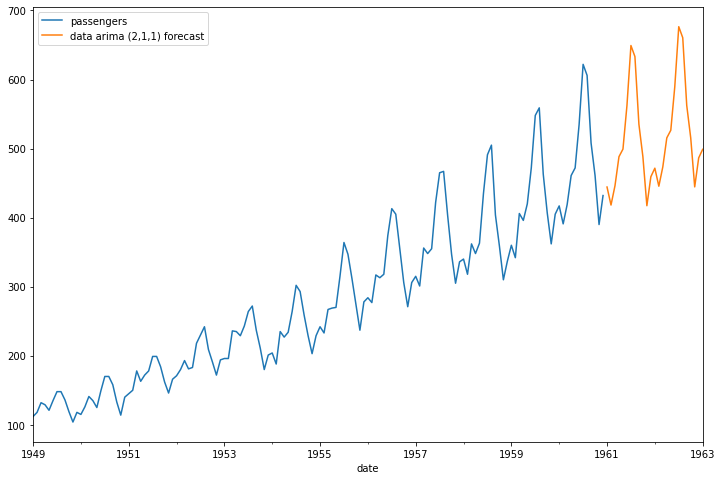

In [41]:
df['passengers'].plot(figsize=(12,8),legend=True)
forecast1.plot(legend=True)


Facebook Prophet

In [ ]:
fb=pd.read_csv('/content/drive/My Drive/airline_passengers.csv')

In [ ]:
fb.columns=['ds','y']

In [ ]:
fb.dropna(inplace=True)

In [ ]:
fb['ds']=pd.to_datetime(fb.ds)

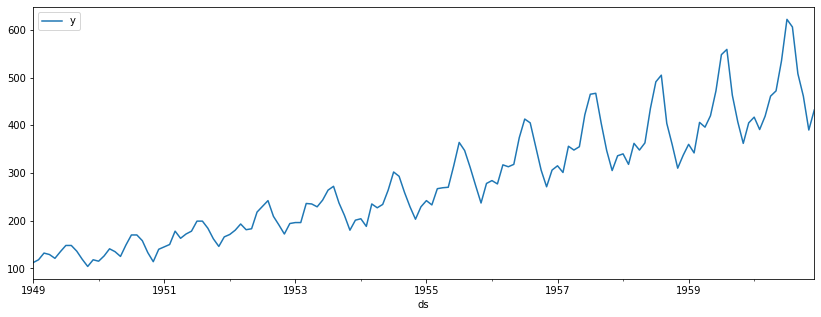

In [ ]:
fb.plot(x='ds',y='y')

In [ ]:
len(fb)

144

In [ ]:
train=fb[:132]
test=fb[132:]

In [ ]:
m=Prophet(seasonality_mode='multiplicative')
m.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future=m.make_future_dataframe(periods=12,freq='MS')

In [ ]:
forecast=m.predict(future)

In [ ]:
fb.head()

,ds,y
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


In [ ]:
forecast[['ds', 'trend', 'yhat_lower', 'yhat_upper',
       'multiplicative_terms', 'yearly', 'yearly_lower', 'yearly_upper',
       'yhat']].head()

,ds,trend,yhat_lower,yhat_upper,multiplicative_terms,yearly,yearly_lower,yearly_upper,yhat
0,1949-01-01,115.603966,91.343547,116.025195,-0.101135,-0.101135,-0.101135,-0.101135,103.912403
1,1949-02-01,117.275019,85.931651,112.078659,-0.154216,-0.154216,-0.154216,-0.154216,99.189377
2,1949-03-01,118.784358,106.218051,132.100770,0.002721,0.002721,0.002721,0.002721,119.107520
3,1949-04-01,120.455412,104.079278,128.796974,-0.033256,-0.033256,-0.033256,-0.033256,116.449565
4,1949-05-01,122.072561,107.273021,131.026564,-0.027357,-0.027357,-0.027357,-0.027357,118.733027


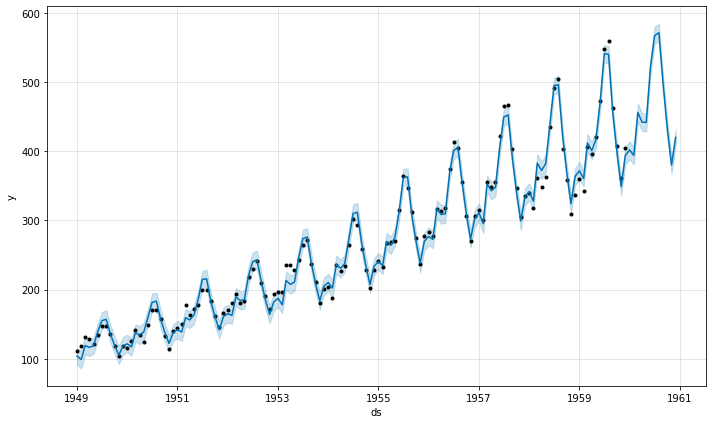

In [ ]:
m.plot(forecast);

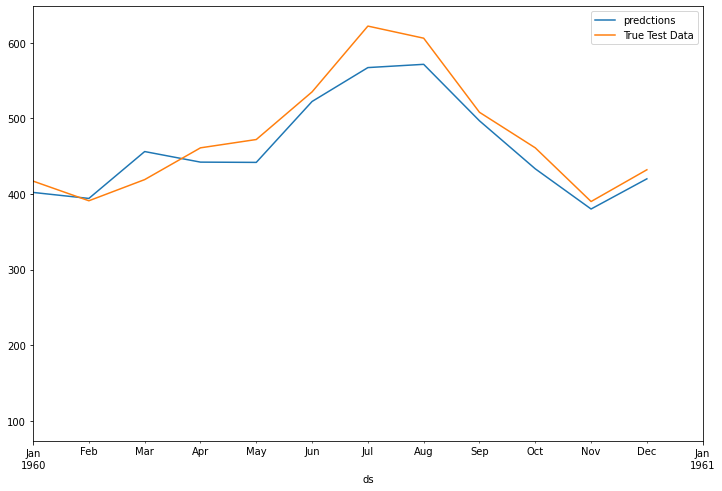

In [ ]:
ax=forecast.plot(x='ds',y='yhat',legend=True,label='predctions',figsize=(12,8))
test.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax,xlim=('1960-01-01','1961-01-01'))

In [ ]:
predictions=forecast.iloc[-12:]['yhat']
predictions

132    402.022536
133    394.089864
134    456.083466
135    442.095362
136    441.751847
137    522.309634
138    567.116400
139    571.429406
140    496.740080
141    433.249511
142    380.107580
143    420.009049
Name: yhat, dtype: float64

In [ ]:
test['y']

132    417.0
133    391.0
134    419.0
135    461.0
136    472.0
137    535.0
138    622.0
139    606.0
140    508.0
141    461.0
142    390.0
143    432.0
Name: y, dtype: float64

In [ ]:
rmse(predictions,test['y'])

26.439065952225352

In [ ]:
# Intial
initial= 2*365
initial= str(initial)+' days'

initial

'730 days'

In [ ]:
period= 2*365
period=str(period)+' days'

period

'730 days'

In [ ]:
horizon = 365
horizon=str(horizon)+' days'
horizon

'365 days'

In [ ]:
fb_cv=cross_validation(m,initial=initial,period=period,horizon=horizon)

INFO:fbprophet:Making 4 forecasts with cutoffs between 1952-12-02 00:00:00 and 1958-12-01 00:00:00


In [ ]:
len(fb_cv)

48

In [ ]:
fb_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1953-01-01,194.397499,190.281058,198.266615,196.0,1952-12-02
1,1953-02-01,212.309974,208.172651,216.974323,196.0,1952-12-02
2,1953-03-01,229.773063,225.157753,234.321703,236.0,1952-12-02
3,1953-04-01,216.845885,212.311015,221.214574,235.0,1952-12-02
4,1953-05-01,214.422492,209.956608,218.541914,229.0,1952-12-02


In [ ]:
performance_metrics(fb_cv)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,31 days,83.598344,9.143213,8.115745,0.028862,0.025992,0.50
1,61 days,105.318032,10.262457,8.838081,0.035475,0.025992,0.50
2,62 days,235.355447,15.341299,13.616275,0.051180,0.057404,0.25
3,89 days,177.936300,13.339277,10.713799,0.035330,0.038033,0.25
4,90 days,60.238763,7.761363,5.135259,0.016651,0.013268,0.50
5,120 days,196.437363,14.015611,12.092810,0.044147,0.049594,0.25
6,121 days,190.007762,13.784330,12.094159,0.044296,0.048650,0.25
7,150 days,122.607723,11.072837,9.733939,0.035413,0.037681,0.25
8,151 days,151.376528,12.303517,11.810656,0.039455,0.037176,0.25
9,181 days,409.895821,20.245884,15.433814,0.045871,0.028428,0.50


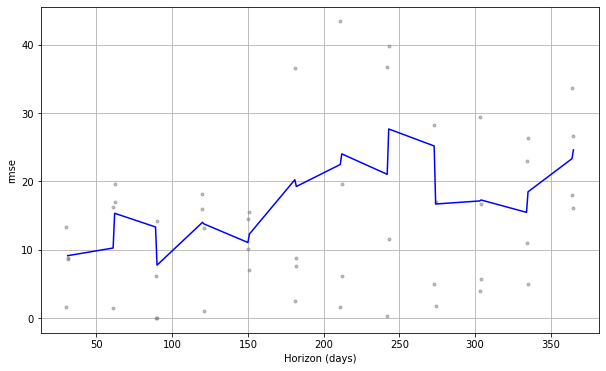

In [ ]:
plot_cross_validation_metric(fb_cv,'rmse');

In [ ]:
# changing trend points

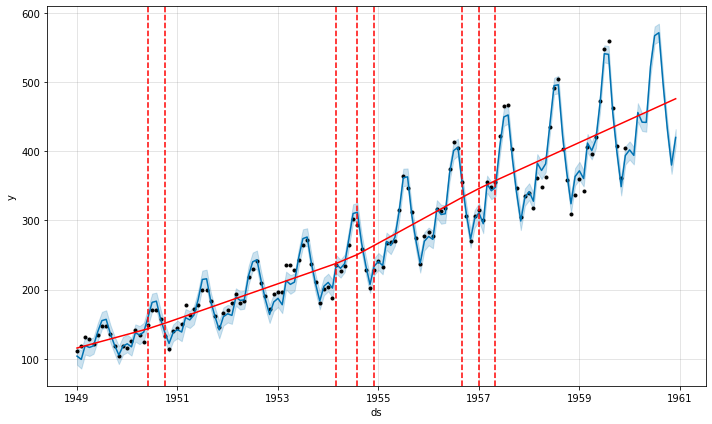

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
fig=m.plot(forecast)
a=add_changepoints_to_plot(fig.gca(),m,forecast)

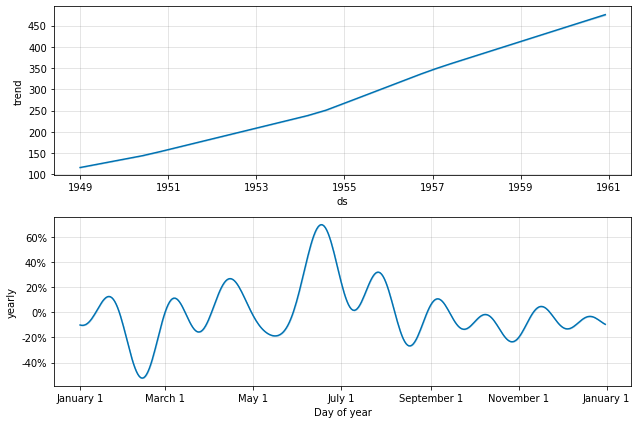

In [ ]:
# changing seasonality

fig=m.plot_components(forecast);

Deep Learning

In [ ]:
train=df[:132]
test=df[132:]

In [ ]:
scaler=MinMaxScaler()
scaled_train=scaler.fit_transform(train)
scaled_test=scaler.transform(test)

In [ ]:
n_input=12
n_features=1

In [ ]:
train_generator=TimeseriesGenerator(scaled_train,scaled_train,n_input,batch_size=1)

In [ ]:
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(n_input,n_features),return_sequences=True))
model.add(LSTM(50,activation='relu',return_sequences=True))
model.add(LSTM(10,activation='relu'))
model.add(Dense(1))

In [ ]:
model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 12, 100)           40800     
_________________________________________________________________
lstm_6 (LSTM)                (None, 12, 50)            30200     
_________________________________________________________________
lstm_7 (LSTM)                (None, 10)                2440      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 73,451
Trainable params: 73,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(train_generator,epochs=30)

Epoch 1/30
120/120 [==============================] - 6s 54ms/step - loss: 0.0645
Epoch 2/30
120/120 [==============================] - 6s 54ms/step - loss: 0.0204
Epoch 3/30
120/120 [==============================] - 6s 51ms/step - loss: 0.0157
Epoch 4/30
120/120 [==============================] - 6s 52ms/step - loss: 0.0097
Epoch 5/30
120/120 [==============================] - 6s 53ms/step - loss: 0.0100
Epoch 6/30
120/120 [==============================] - 6s 51ms/step - loss: 0.0087
Epoch 7/30
120/120 [==============================] - 6s 51ms/step - loss: 0.0089
Epoch 8/30
120/120 [==============================] - 6s 54ms/step - loss: 0.0093
Epoch 9/30
120/120 [==============================] - 6s 53ms/step - loss: 0.0114
Epoch 10/30
120/120 [==============================] - 6s 54ms/step - loss: 0.0240
Epoch 11/30
120/120 [==============================] - 6s 54ms/step - loss: 0.0101
Epoch 12/30
120/120 [==============================] - 6s 52ms/step - loss: 0.0087
Epoch 13/30
1

In [ ]:
model.history.history.keys()

dict_keys(['loss'])

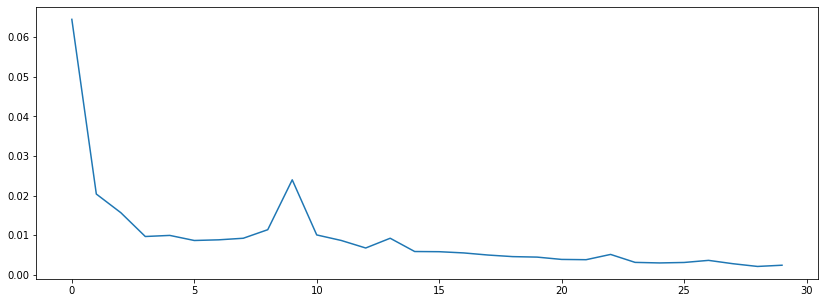

In [ ]:
myloss=model.history.history['loss']
plt.plot(range(len(myloss)),myloss)

In [ ]:
first_eval_batch=scaled_train[-12:]

In [ ]:
first_eval_batch

array([[0.56263736],
       [0.52307692],
       [0.66373626],
       [0.64175824],
       [0.69450549],
       [0.80879121],
       [0.97582418],
       [1.        ],
       [0.78901099],
       [0.66593407],
       [0.56703297],
       [0.66153846]])

In [ ]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [ ]:
model.predict(first_eval_batch)

array([[0.64479584]], dtype=float32)

In [ ]:
scaled_test[0]

array([0.68791209])

In [ ]:
test_predictions = []

#Select last n_input values from the train data
first_eval_batch = scaled_train[-n_input:]

#reshape the data into LSTM required (#batch,#timesteps,#features)
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
# get prediction, grab the exact number using the [0]
  pred = model.predict(current_batch)[0]
# Add this prediction to the list
  test_predictions.append(pred)
# The most critical part, update the (#batch,#timesteps,#features
# using np.append(
# current_batch[:        ,1:   ,:] ---------> read this as
# current_batch[no_change,1:end,no_change]
# (Do note the second part has the timesteps)
# [[pred]] need the double brackets as current_batch is a 3D array
# axis=1, remember we need to add to the second part i.e. 1st axis
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
test_predictions

[array([0.64479584], dtype=float32),
 array([0.6381964], dtype=float32),
 array([0.7760339], dtype=float32),
 array([0.7662979], dtype=float32),
 array([0.85754603], dtype=float32),
 array([1.0440366], dtype=float32),
 array([1.164077], dtype=float32),
 array([1.1348602], dtype=float32),
 array([0.9243323], dtype=float32),
 array([0.7622995], dtype=float32),
 array([0.67176056], dtype=float32),
 array([0.80623347], dtype=float32)]

In [ ]:
scaled_test

array([[0.68791209],
       [0.63076923],
       [0.69230769],
       [0.78461538],
       [0.80879121],
       [0.94725275],
       [1.13846154],
       [1.1032967 ],
       [0.88791209],
       [0.78461538],
       [0.62857143],
       [0.72087912]])

In [ ]:
actual_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
actual_predictions

array([[397.38210493],
       [394.37936598],
       [457.09541464],
       [452.66553396],
       [494.18344432],
       [579.0366652 ],
       [633.65505481],
       [620.36137187],
       [524.57120591],
       [450.84626251],
       [409.65105438],
       [470.83622688]])

In [ ]:
test

,passengers,Predictions
date,,
1960-01-01,417.0,397.382105
1960-02-01,391.0,394.212035
1960-03-01,419.0,456.629355
1960-04-01,461.0,452.074126
1960-05-01,472.0,493.523883
1960-06-01,535.0,578.633769
1960-07-01,622.0,633.919910
1960-08-01,606.0,621.221785
1960-09-01,508.0,526.150519


In [ ]:
test['Predictions'] = actual_predictions

In [ ]:
test

,passengers,Predictions
date,,
1960-01-01,417.0,397.382105
1960-02-01,391.0,394.379366
1960-03-01,419.0,457.095415
1960-04-01,461.0,452.665534
1960-05-01,472.0,494.183444
1960-06-01,535.0,579.036665
1960-07-01,622.0,633.655055
1960-08-01,606.0,620.361372
1960-09-01,508.0,524.571206


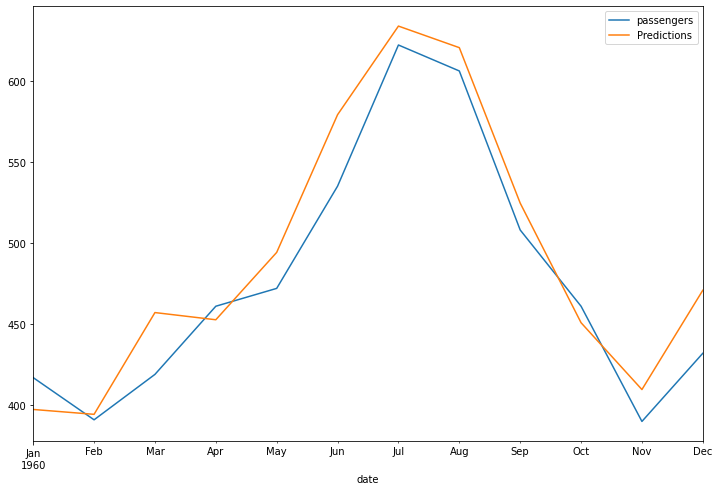

In [ ]:
test.plot(figsize=(12,8));